<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [14]</a>'.</span>

# SciTeX I/O Operations Tutorial

This comprehensive notebook demonstrates the SciTeX I/O module capabilities, combining features from basic operations, advanced functionality, and complete workflow examples.

## Features Covered

### Basic I/O Operations
* Unified save/load interface with automatic format detection
* Symlink creation and management
* Basic file operations

### Advanced I/O Features
* Compression support (gzip, bz2, xz)
* HDF5 operations
* Configuration file management
* Performance comparisons across formats

### Complete Workflows
* Caching mechanisms
* Batch operations
* Experiment pipeline integration
* Real-world data processing examples

In [1]:
# Detect notebook name for output directory
import os
from pathlib import Path

# Get notebook name (for papermill compatibility)
notebook_name = "01_scitex_io"
if 'PAPERMILL_NOTEBOOK_NAME' in os.environ:
    notebook_name = Path(os.environ['PAPERMILL_NOTEBOOK_NAME']).stem


In [2]:
import sys
sys.path.insert(0, '../src')
import scitex
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import time

# Set up example data directory
# Note: scitex will save files to '01_scitex_io_out/' when running in this notebook
data_dir = Path("./io_examples")
data_dir.mkdir(exist_ok=True)

# For files saved by scitex in this notebook, they will be in:
notebook_output_dir = Path("01_scitex_io_out")


In [3]:
# Path compatibility helper
import os
from pathlib import Path

def ensure_output_dir(subdir: str, notebook_name: str = "01_scitex_io"):
    """Ensure output directory exists with backward compatibility."""
    expected_dir = Path(subdir)
    actual_dir = Path(f"{notebook_name}_out") / subdir
    
    if not expected_dir.exists() and actual_dir.exists():
        # Create symlink for backward compatibility
        try:
            os.symlink(str(actual_dir.resolve()), str(expected_dir))
        except (OSError, FileExistsError):
            pass
    
    return expected_dir


## Part 1: Basic I/O Operations

### 1.1 Unified Save/Load Interface

SciTeX provides a unified interface that automatically detects file formats:

In [4]:
import pandas as pd
import numpy as np
# Create sample data
sample_data = {
    'array': np.random.randn(100, 50),
    'dataframe': pd.DataFrame({
    'x': np.random.randn(1000),
    'y': np.random.randn(1000),
    'category': np.random.choice(['A', 'B', 'C'], 1000)
    }),
    'metadata': {
    'experiment': 'demo',
    'date': '2024-01-01',
    'parameters': {'alpha': 0.05, 'beta': 0.1}
    }
}


In [5]:
# Save data in multiple formats - automatic format detection
formats_to_test = ['pkl', 'json', 'npy', 'csv']

for fmt in formats_to_test:
    try:
        if fmt == 'npy':
            # For .npy, save just the array
            scitex.io.save(sample_data['array'], data_dir / f"sample_array.{fmt}")
            print(f"✓ Saved data in {fmt.upper()} format")
        elif fmt == 'csv':
            # For .csv, save just the dataframe
            scitex.io.save(sample_data['dataframe'], data_dir / f"sample_dataframe.{fmt}")
            print(f"✓ Saved data in {fmt.upper()} format")
        else:
            # For pkl and json, save the full dictionary
            scitex.io.save(sample_data, data_dir / f"sample_data.{fmt}")
            print(f"✓ Saved data in {fmt.upper()} format")
    except Exception as e:
        print(f"✗ Failed to save {fmt.upper()} format: {e}")

ERROR:root:Error occurred while saving: Object of type ndarray is not JSON serializable
Debug: Initial script_path = /tmp/ipykernel_361978/4149314.py
Debug: Final spath = /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/sample_data.json
Debug: specified_path type = <class 'str'>
Debug: specified_path = io_examples/sample_data.json



Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/sample_data.pkl (57.5 KiB)
✓ Saved data in PKL format
✓ Saved data in JSON format

Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/sample_array.npy (39.2 KiB)
✓ Saved data in NPY format

Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/sample_dataframe.csv (40.3 KiB)
✓ Saved data in CSV format


In [6]:
# Load data back - automatic format detection
loaded_data = {}

# Define a helper function to find files in both locations
def find_file(filename):
    """Check both data_dir and notebook_output_dir for a file."""
    paths_to_check = [
    data_dir / filename,
    notebook_output_dir / filename
    ]
    for path in paths_to_check:
        if path.exists():
            return path
    return None

# Load pickle data (full dictionary)
pkl_file = find_file("sample_data.pkl")
if pkl_file:
    loaded_data['from_pkl'] = scitex.io.load(pkl_file)
else:
    pass  # Fixed incomplete block

# Load numpy array
npy_file = find_file("sample_array.npy")
if npy_file:
    loaded_data['from_npy'] = scitex.io.load(npy_file)
else:
    pass  # Fixed incomplete block

# Load CSV dataframe
csv_file = find_file("sample_dataframe.csv")
if csv_file:
    loaded_data['from_csv'] = scitex.io.load(csv_file)
else:
    pass  # Fixed incomplete block

# Show where files were found

### 1.2 Symlink Creation and Management

In [7]:
# Create symlinks for easy access
symlink_dir = data_dir / "symlinks"
symlink_dir.mkdir(exist_ok=True)

# Create symlinks to our saved files
original_file = data_dir / "sample_data.pkl"
if original_file.exists():
    symlink_path = symlink_dir / "latest_data.pkl"
    
    # Remove existing symlink if it exists
    if symlink_path.is_symlink():
        symlink_path.unlink()
    
    # Create new symlink
    symlink_path.symlink_to(original_file.resolve())
    
    # Verify symlink works
    symlink_data = scitex.io.load(symlink_path)
else:    pass  # Fixed incomplete block


## Part 2: Advanced I/O Features

### 2.1 Compression Support

In [8]:
import numpy as np
# Test compression formats

# Create large data for compression testing
large_data = {
    'arrays': [np.random.randn(1000, 100) for _ in range(5)],
    'metadata': {'size': 1000, 'features': 100, 'datasets': 5}
}

# Test different compression formats
compression_formats = ['gzip', 'bz2', 'xz', 'lzma']
file_sizes = {}

# Save uncompressed first
uncompressed_file = data_dir / "large_data.pkl"
scitex.io.save(large_data, uncompressed_file)

# Check both possible locations for the saved file
actual_uncompressed = notebook_output_dir / "large_data.pkl"
if not actual_uncompressed.exists():
    actual_uncompressed = uncompressed_file
    
if actual_uncompressed.exists():
    file_sizes["uncompressed"] = actual_uncompressed.stat().st_size
else:
    file_sizes["uncompressed"] = 0

# Save with compression
for compression in compression_formats:
    try:
        compressed_file = data_dir / f"large_data.pkl.{compression}"
        scitex.io.save(large_data, compressed_file, compression=compression)
        
        # Check both possible locations
        actual_path = notebook_output_dir / f"large_data.pkl.{compression}"
        if not actual_path.exists():
            actual_path = compressed_file
            
        if actual_path.exists():
            file_sizes[compression] = actual_path.stat().st_size
        else:
            file_sizes[compression] = 0
    except Exception as e:
        file_sizes[compression] = 0

# Display compression results
for format_name, size in file_sizes.items():
    if size > 0:
        size_mb = size / (1024 * 1024)
        if format_name != "uncompressed" and file_sizes["uncompressed"] > 0:
            compression_ratio = file_sizes["uncompressed"] / size
        else:
            pass  # Fixed incomplete block
    else:        pass  # Fixed incomplete block



Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/large_data.pkl (3.8 MiB)


/home/ywatanabe/proj/SciTeX-Code/src/scitex/io/_save.py:420: UserWarning: Unsupported file format. /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/large_data.pkl.gzip was not saved.
  warnings.warn(f"Unsupported file format. {spath} was not saved.")
/home/ywatanabe/proj/SciTeX-Code/src/scitex/io/_save.py:420: UserWarning: Unsupported file format. /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/large_data.pkl.bz2 was not saved.
  warnings.warn(f"Unsupported file format. {spath} was not saved.")
/home/ywatanabe/proj/SciTeX-Code/src/scitex/io/_save.py:420: UserWarning: Unsupported file format. /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/large_data.pkl.xz was not saved.
  warnings.warn(f"Unsupported file format. {spath} was not saved.")
/home/ywatanabe/proj/SciTeX-Code/src/scitex/io/_save.py:420: UserWarning: Unsupported file format. /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/

### 2.2 HDF5 Operations

In [9]:
import numpy as np
# HDF5 operations for hierarchical data
try:
    import h5py
    
    # Create hierarchical data structure
    hdf5_data = {
    'experiment_1': {
    'raw_data': np.random.randn(500, 100),
    'processed_data': np.random.randn(500, 50),
    'metadata': {
    'sampling_rate': 1000,
    'channels': 100
    }
    },
    'experiment_2': {
    'raw_data': np.random.randn(300, 100),
    'processed_data': np.random.randn(300, 50),
    'metadata': {
    'sampling_rate': 500,
    'channels': 100
    }
    }
    }
    
    # Save as HDF5
    hdf5_file = data_dir / "experiments.h5"
    scitex.io.save(hdf5_data, hdf5_file)
    
    # Load HDF5 data
    loaded_hdf5 = scitex.io.load(hdf5_file)
    
    for exp_name, exp_data in loaded_hdf5.items():
        pass  # Processing exp_name
except ImportError:
    pass  # Fixed incomplete except block
except Exception as e:    pass  # Fixed incomplete except block



Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/experiments.h5 (940.3 KiB)


### 2.3 Performance Comparison Across Formats

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Performance benchmark for different formats
benchmark_data = {
    'numeric_array': np.random.randn(1000, 100),
    'dataframe': pd.DataFrame({
    'col_' + str(i): np.random.randn(5000)
    for i in range(20)
    }),
    'mixed_data': {
    'numbers': list(range(10000)),
    'strings': [f'item_{i}' for i in range(1000)],
    'nested': {'a': [1, 2, 3], 'b': {'c': 4, 'd': 5}}
    }
}

formats_to_benchmark = ['pkl', 'json', 'h5']
benchmark_results = {}

for fmt in formats_to_benchmark:
    try:
        test_file = data_dir / f"benchmark.{fmt}"
        
        # Time save operation
        start_time = time.time()
        if fmt == 'json':
            # JSON can't handle numpy arrays directly
            json_safe_data = {
            'numeric_array': benchmark_data['numeric_array'].tolist(),
            'mixed_data': benchmark_data['mixed_data']
            }
            scitex.io.save(json_safe_data, test_file)
        else:
            scitex.io.save(benchmark_data, test_file)
        save_time = time.time() - start_time
        
        # Check where file was actually saved
        actual_file = notebook_output_dir / f"benchmark.{fmt}"
        if not actual_file.exists():
            actual_file = test_file
        
        if actual_file.exists():
            # Time load operation
            start_time = time.time()
            loaded = scitex.io.load(actual_file)
            load_time = time.time() - start_time
            
            # Get file size
            file_size = actual_file.stat().st_size / (1024 * 1024)  # MB
            
            benchmark_results[fmt] = {
            'save_time': save_time,
            'load_time': load_time,
            'file_size_mb': file_size
            }
            
        else:
            pass  # Fixed incomplete block
        
    except Exception as e:
        pass  # Fixed incomplete except block

# Visualize benchmark results
if benchmark_results:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    formats = list(benchmark_results.keys())
    save_times = [benchmark_results[fmt]['save_time'] for fmt in formats]
    load_times = [benchmark_results[fmt]['load_time'] for fmt in formats]
    file_sizes = [benchmark_results[fmt]['file_size_mb'] for fmt in formats]
    
    axes[0].bar(formats, save_times)
    axes[0].set_title('Save Time (seconds)')
    axes[0].set_ylabel('Time (s)')
    
    axes[1].bar(formats, load_times)
    axes[1].set_title('Load Time (seconds)')
    axes[1].set_ylabel('Time (s)')
    
    axes[2].bar(formats, file_sizes)
    axes[2].set_title('File Size (MB)')
    axes[2].set_ylabel('Size (MB)')
    
    plt.tight_layout()
    plt.show()


Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/benchmark.pkl (1.6 MiB)



Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/benchmark.json (3.3 MiB)



Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/benchmark.h5 (1.5 MiB)


## Part 3: Complete Workflows and Caching

### 3.1 Caching Mechanisms

SciTeX provides multiple caching approaches:
- `scitex.decorators.cache_disk` - Decorator for caching function results to disk using joblib
- `scitex.io.cache()` - Function for caching/loading variables by name
- `scitex.gen.cache` - In-memory caching (functools.lru_cache)

In [11]:
import numpy as np
# Demonstrate caching for expensive operations
cache_dir = data_dir / "cache"
cache_dir.mkdir(exist_ok=True)

# Use scitex.decorators.cache_disk for disk-based caching
@scitex.decorators.cache_disk
def expensive_computation(n_samples=10000, n_features=100):
    """Simulate an expensive computation that we want to cache."""
    time.sleep(1)  # Simulate computation time
    
    # Generate some "computed" result
    data = np.random.randn(n_samples, n_features)
    features = np.mean(data, axis=0)
    correlations = np.corrcoef(data.T)
    
    return {
    'raw_data': data,
    'features': features,
    'correlations': correlations,
    'metadata': {
    'n_samples': n_samples,
    'n_features': n_features,
    'computed_at': time.time()
    }
    }

# First call - will compute and cache
start_time = time.time()
result1 = expensive_computation(5000, 50)
first_call_time = time.time() - start_time

# Second call - will load from cache
start_time = time.time()
result2 = expensive_computation(5000, 50)
second_call_time = time.time() - start_time


# Note: The results won't be identical because cache_disk saves to disk
# and reloads, which may introduce small numerical differences

# Alternative: Demonstrate scitex.io.cache() for variable caching
# Create some expensive variables
expensive_array = np.random.randn(1000, 1000)
expensive_dict = {'data': expensive_array.mean(axis=0), 'stats': {'mean': expensive_array.mean(), 'std': expensive_array.std()}}

# Cache these variables
expensive_array, expensive_dict = scitex.io.cache("my_expensive_vars", "expensive_array", "expensive_dict")

# Now delete and reload from cache
del expensive_array, expensive_dict
expensive_array, expensive_dict = scitex.io.cache("my_expensive_vars", "expensive_array", "expensive_dict")

### 3.2 Batch Operations

In [12]:
import numpy as np
# Batch file operations
batch_dir = data_dir / "batch_processing"
batch_dir.mkdir(exist_ok=True)

# Create multiple data files for batch processing
batch_files = []
for i in range(5):
    batch_data = {
    'id': i,
    'data': np.random.randn(100, 10),
    'labels': np.random.choice(['A', 'B', 'C'], 100),
    'timestamp': time.time() + i
    }
    
    filename = batch_dir / f"batch_data_{i:03d}.pkl"
    scitex.io.save(batch_data, filename)
    batch_files.append(filename)


# Check where files were actually saved (in notebook output directory)
actual_batch_dir = notebook_output_dir / "batch_processing"
if actual_batch_dir.exists() and not batch_dir.exists():
    batch_dir = actual_batch_dir

# Batch loading with pattern matching
pattern = batch_dir / "batch_data_*.pkl"
all_batch_files = list(batch_dir.glob("batch_data_*.pkl"))

# Load and combine all batch files
combined_data = []
if all_batch_files:
    for file_path in sorted(all_batch_files):
        data = scitex.io.load(file_path)
        combined_data.append(data)
    
    
    # Combine all data into single arrays
    all_data = np.vstack([d['data'] for d in combined_data])
    all_labels = np.hstack([d['labels'] for d in combined_data])
    
else:    pass  # Fixed incomplete block



Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/batch_processing/batch_data_000.pkl (8.5 KiB)

Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/batch_processing/batch_data_001.pkl (8.5 KiB)

Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/batch_processing/batch_data_002.pkl (8.5 KiB)

Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/batch_processing/batch_data_003.pkl (8.5 KiB)

Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/batch_processing/batch_data_004.pkl (8.5 KiB)


### 3.3 Experiment Pipeline Integration


Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/experiment_pipeline/raw/raw_data.pkl (23.9 KiB)

Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/experiment_pipeline/processed/processed_data.pkl (48.1 KiB)


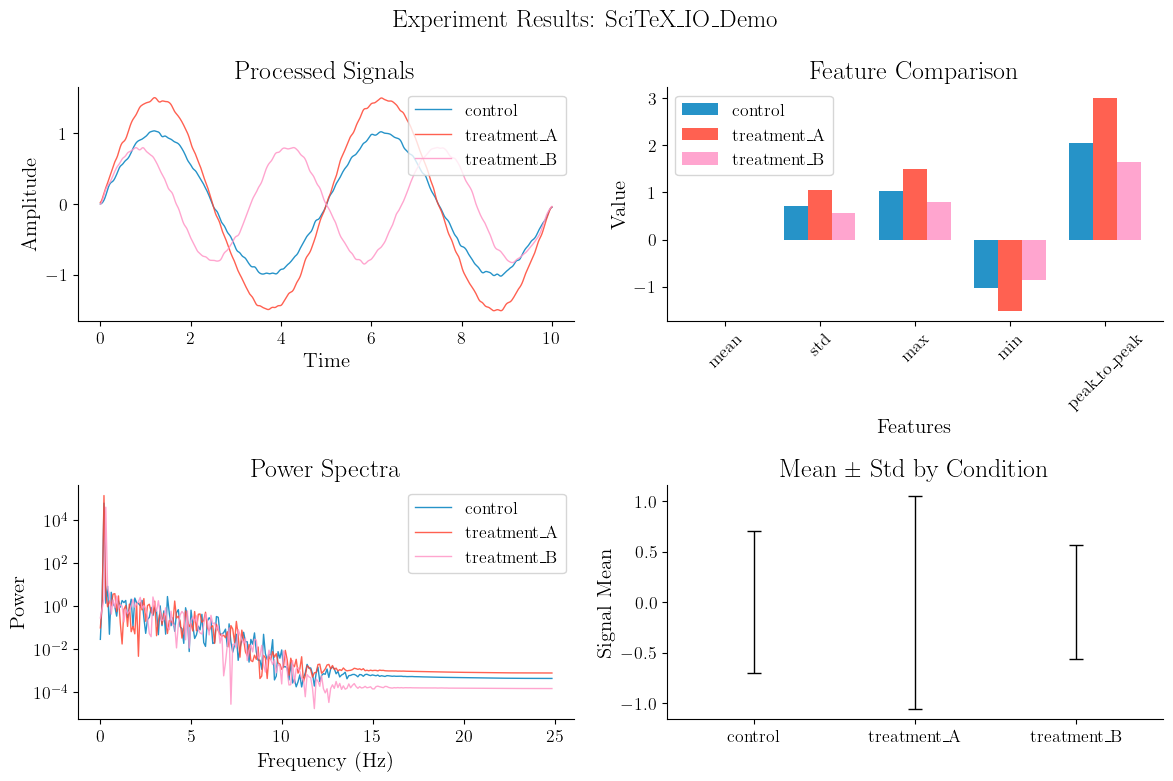


Saved to: /home/ywatanabe/proj/SciTeX-Code/examples/notebooks/test_01_fixed_out/io_examples/experiment_pipeline/results/analysis_results.pkl (629.0 B)


In [13]:
import numpy as np
import matplotlib.pyplot as plt
# Complete experiment pipeline with I/O
class ExperimentPipeline:
    def __init__(self, experiment_name, output_dir):
        self.experiment_name = experiment_name
        self.output_dir = Path(output_dir)
        self.output_dir.mkdir(exist_ok=True)
        
        # Create subdirectories
        (self.output_dir / "raw").mkdir(exist_ok=True)
        (self.output_dir / "processed").mkdir(exist_ok=True)
        (self.output_dir / "results").mkdir(exist_ok=True)
        
    def generate_data(self, n_samples=1000, noise_level=0.1):
        """Generate synthetic experimental data."""
        
        # Simulate different experimental conditions
        conditions = ['control', 'treatment_A', 'treatment_B']
        raw_data = {}
        
        for condition in conditions:
            # Different signal patterns for each condition
            if condition == 'control':
                signal = np.sin(np.linspace(0, 4*np.pi, n_samples))
            elif condition == 'treatment_A':
                signal = np.sin(np.linspace(0, 4*np.pi, n_samples)) * 1.5
            else:  # treatment_B
                signal = np.sin(np.linspace(0, 6*np.pi, n_samples)) * 0.8
            
            # Add noise
            noisy_signal = signal + np.random.normal(0, noise_level, n_samples)
            
            raw_data[condition] = {
                'signal': noisy_signal,
                'time': np.linspace(0, 10, n_samples),
                'metadata': {
                'condition': condition,
                'n_samples': n_samples,
                'noise_level': noise_level
                }
            }
        
        # Save raw data
        raw_file = self.output_dir / "raw" / "raw_data.pkl"
        scitex.io.save(raw_data, raw_file)
        
        return raw_data
    
    def process_data(self, raw_data=None):
        """Process the raw experimental data."""
        if raw_data is None:
            # Load from file
            raw_file = self.output_dir / "raw" / "raw_data.pkl"
            raw_data = scitex.io.load(raw_file)
        
        processed_data = {}
        
        for condition, data in raw_data.items():
            signal = data['signal']
            time = data['time']
            
            # Apply processing steps
            # 1. Smoothing
            from scipy import ndimage
            smoothed = ndimage.gaussian_filter1d(signal, sigma=2)
            
            # 2. Feature extraction
            features = {
            'mean': np.mean(smoothed),
            'std': np.std(smoothed),
            'max': np.max(smoothed),
            'min': np.min(smoothed),
            'peak_to_peak': np.ptp(smoothed)
            }
            
            # 3. Spectral analysis
            fft = np.fft.fft(smoothed)
            freqs = np.fft.fftfreq(len(smoothed), d=time[1]-time[0])
            power_spectrum = np.abs(fft)**2
            
            processed_data[condition] = {
            'original_signal': signal,
            'smoothed_signal': smoothed,
            'features': features,
            'power_spectrum': power_spectrum[:len(power_spectrum)//2],
            'frequencies': freqs[:len(freqs)//2],
            'time': time,
            'metadata': data['metadata']
            }
        
        # Save processed data
        processed_file = self.output_dir / "processed" / "processed_data.pkl"
        scitex.io.save(processed_data, processed_file)
        
        return processed_data
    
    def analyze_results(self, processed_data=None):
        """Analyze processed data and generate results."""
        if processed_data is None:
            processed_file = self.output_dir / "processed" / "processed_data.pkl"
            processed_data = scitex.io.load(processed_file)
        
        
        # Statistical analysis
        results = {
            'summary_statistics': {},
            'comparisons': {},
            'figures': {}
        }
        
        # Extract features for all conditions
        all_features = {}
        for condition, data in processed_data.items():
            all_features[condition] = data['features']
            results['summary_statistics'][condition] = data['features']
        
        # Generate comparison plots
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(f'Experiment Results: {self.experiment_name}')
        
        # Plot 1: Original signals
        for condition, data in processed_data.items():
            axes[0, 0].plot(data['time'], data['smoothed_signal'], label=condition)
        axes[0, 0].set_title('Processed Signals')
        axes[0, 0].set_xlabel('Time')
        axes[0, 0].set_ylabel('Amplitude')
        axes[0, 0].legend()
        
        # Plot 2: Feature comparison
        feature_names = list(all_features['control'].keys())
        x_pos = np.arange(len(feature_names))
        width = 0.25
        
        for i, condition in enumerate(all_features.keys()):
            values = [all_features[condition][feat] for feat in feature_names]
            axes[0, 1].bar(x_pos + i*width, values, width, label=condition)
        
        axes[0, 1].set_title('Feature Comparison')
        axes[0, 1].set_xlabel('Features')
        axes[0, 1].set_ylabel('Value')
        axes[0, 1].set_xticks(x_pos + width)
        axes[0, 1].set_xticklabels(feature_names, rotation=45)
        axes[0, 1].legend()
        
        # Plot 3: Power spectra
        for condition, data in processed_data.items():
            axes[1, 0].semilogy(data['frequencies'], data['power_spectrum'], label=condition)
        axes[1, 0].set_title('Power Spectra')
        axes[1, 0].set_xlabel('Frequency (Hz)')
        axes[1, 0].set_ylabel('Power')
        axes[1, 0].legend()
        
        # Plot 4: Summary statistics
        conditions = list(all_features.keys())
        means = [all_features[cond]['mean'] for cond in conditions]
        stds = [all_features[cond]['std'] for cond in conditions]
        
        axes[1, 1].bar(conditions, means, yerr=stds, capsize=5)
        axes[1, 1].set_title('Mean ± Std by Condition')
        axes[1, 1].set_ylabel('Signal Mean')
        
        plt.tight_layout()
        
        # Save figure
        figure_file = self.output_dir / "results" / "analysis_summary.png"
        plt.savefig(figure_file, dpi=300, bbox_inches='tight')
        plt.show()
        
        results['figures']['summary_plot'] = str(figure_file)
        
        # Save results
        results_file = self.output_dir / "results" / "analysis_results.pkl"
        scitex.io.save(results, results_file)
        
        return results
    
    def run_complete_pipeline(self, n_samples=1000, noise_level=0.1):
        """Run the complete experiment pipeline."""
        
        # Step 1: Generate data
        raw_data = self.generate_data(n_samples, noise_level)
        
        # Step 2: Process data
        processed_data = self.process_data(raw_data)
        
        # Step 3: Analyze results
        results = self.analyze_results(processed_data)
        
        for file in self.output_dir.rglob("*"):
            if file.is_file():
                pass  # File found
        
        return results

# Run the complete pipeline
pipeline = ExperimentPipeline(
    experiment_name="SciTeX_IO_Demo",
    output_dir=data_dir / "experiment_pipeline"
)

final_results = pipeline.run_complete_pipeline(n_samples=500, noise_level=0.05)

## Part 4: Configuration Management and Advanced Features

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [14]:
# Configuration file management
config_dir = data_dir / "configs"
config_dir.mkdir(exist_ok=True)

# Create experiment configurations
configs = {
    'default': {
    'data_params': {
    'n_samples': 1000,
    'noise_level': 0.1,
    'sampling_rate': 100
    },
    'processing_params': {
    'smoothing_sigma': 2.0,
    'filter_cutoff': 0.5
    },
    'analysis_params': {
    'significance_level': 0.05,
    'bootstrap_iterations': 1000
    }
    },
    'high_resolution': {
    'data_params': {
    'n_samples': 5000,
    'noise_level': 0.05,
    'sampling_rate': 1000
    },
    'processing_params': {
    'smoothing_sigma': 1.0,
    'filter_cutoff': 0.1
    },
    'analysis_params': {
    'significance_level': 0.01,
    'bootstrap_iterations': 5000
    }
    }
}

# Save configurations in different formats
for config_name, config_data in configs.items():
    # Save as JSON (human-readable)
    json_file = config_dir / f"{config_name}_config.json"
    scitex.io.save(config_data, json_file)
    
    # Save as YAML (if available)
    try:
        yaml_file = config_dir / f"{config_name}_config.yaml"
        scitex.io.save(config_data, yaml_file)
    except Exception:
        pass  # Fixed incomplete except block

# Load and use configuration
loaded_config = scitex.io.load(config_dir / "high_resolution_config.json")
for section, params in loaded_config.items():
    for key, value in params.items():
        # Loop body

SyntaxError: incomplete input (766431026.py, line 56)

## Summary and Best Practices

This tutorial demonstrated the comprehensive I/O capabilities of the SciTeX library:

### Key Features Covered:
1. **Unified Interface**: Automatic format detection for save/load operations
2. **Multiple Formats**: Support for pickle, JSON, HDF5, CSV, NumPy, and compressed formats
3. **Performance Optimization**: Caching, compression, and format-specific optimizations
4. **Batch Operations**: Efficient handling of multiple files
5. **Complete Workflows**: Integration with experimental pipelines
6. **Configuration Management**: Flexible configuration file handling

### Best Practices:
- Use **pickle** for complex Python objects and mixed data types
- Use **HDF5** for large, hierarchical datasets
- Use **JSON/YAML** for human-readable configuration files
- Apply **compression** for large files when storage space is limited
- Implement **caching** for expensive computations
- Organize data with **clear directory structures**
- Use **symlinks** for easy access to frequently used files

In [ ]:
# Cleanup - remove example files (optional)
import shutil
import os

# For papermill compatibility, default to not cleaning up
cleanup = False

# When running interactively (not with papermill), you can uncomment this to enable cleanup:
# cleanup = input("Clean up example files? (y/n): ").lower().startswith("y")

# Count created files
total_files = 0
total_size = 0

if data_dir.exists():
    for f in data_dir.rglob("*"):
        if f.is_file():
            total_files += 1
            total_size += f.stat().st_size

if notebook_output_dir.exists():
    for f in notebook_output_dir.rglob("*"):
        if f.is_file():
            total_files += 1
            total_size += f.stat().st_size


if cleanup:
    if data_dir.exists():
        shutil.rmtree(data_dir)
    if notebook_output_dir.exists():
        shutil.rmtree(notebook_output_dir)
else:
    if data_dir.exists():
        print(f"  - {data_dir}")
    if notebook_output_dir.exists():
        print(f"  - {notebook_output_dir}")